In [1]:
import numpy as np
import numpy.typing as npt
from matplotlib import pyplot as plt
from scipy.special import erf
import os
import pandas as pd
from typing import Union

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Masking, GlobalMaxPooling1D, Input
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

initial_lr = 0.001  # Starting learning rate, adjust as needed
optimizer = Adam(learning_rate=initial_lr)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

/opt/conda/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2024-06-07 03:44:36.487838: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-07 03:44:39.188300: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10398 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:db:00.0, compute capability: 6.1


In [2]:
import pandas as pd
class_info = pd.read_csv('sim6/simulated_flares.csv')

In [3]:
class_info

,Unnamed: 0,identifier,peak_count,flare_class,background_slope,background_intercept,amplitude,mu,sigma,tau,sigma-by-tau,snr,flare_type,discrepancy_flag
0,0,1,831.436623,B8,-0.093638,263.669853,885.862821,638.830933,399.542396,159.060693,2.511886,24299.049873,B,0
1,1,2,2091.737582,C2,0.024822,58.456700,2166.071255,470.563552,125.833680,35.464750,3.548134,18651.198919,A,0
2,2,3,3922.161294,C3,0.023493,290.219479,4035.052241,395.667497,483.061773,121.339631,3.981072,53205.277596,A,1
3,3,4,2569.844834,C2,0.106797,55.317646,2594.630693,620.122604,417.667746,58.997137,7.079458,55159.632668,A,0
4,4,5,1511.007118,C1,0.046458,186.910159,1554.501642,665.798403,195.766885,49.174418,3.981072,20491.219874,A,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8719,8719,9994,340.013805,B3,0.132112,23.843661,539.811854,756.865558,370.150265,658.230596,0.562341,16935.779291,B,0
8720,8720,9995,1311.381430,C1,-0.129941,293.690254,2645.833267,705.799922,434.281758,1223.972294,0.354813,49609.978883,B,0
8721,8721,9997,633.569737,B6,-0.008776,25.868263,1278.287106,827.993831,69.064422,194.649988,0.354813,12308.233653,B,0
8722,8722,9998,212.221647,B2,0.052757,134.921556,2357.524871,500.254710,2.892275,72.650656,0.039811,817.381937,B,0


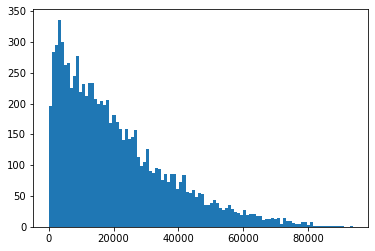

In [4]:
# see the SNR distribution
plt.hist(class_info['snr'], bins = 100);

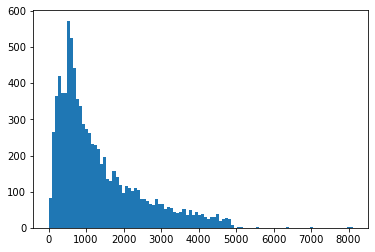

In [5]:
# see peak count distribution
plt.hist(class_info['peak_count'], bins = 100);

# get data

In [6]:
import pandas as pd
from scipy.signal import welch
from tqdm import tqdm

data = []
data_deriv = []
labels = []
ids = []
peak_count = []

tot_flares = 0
maxlen = 0

for i, iden in enumerate(tqdm(np.array(class_info['identifier']))):
    #print(iden)
    try:
        tod = pd.read_csv('sim6/flares/' + f'{i}' + '.csv')
    except FileNotFoundError:
        continue

    if len(tod['Counts']) > maxlen:
        maxlen = len(tod['Counts'])

    tot_flares += 1
    data.append(list(tod['Counts']))
    data_deriv.append(list(np.diff(tod['Counts'])))
    peak_count.append(class_info['peak_count'][i])
    
    if class_info['flare_type'][i] == 'A':
        labels.append(0)
    else:
        labels.append(1)

    ids.append(class_info['identifier'][i])

labels = np.array(labels)

print(tot_flares)

100%|██████████| 8724/8724 [00:19<00:00, 458.69it/s]

7615


In [8]:
# ids = [i for i in class_info['identifier']]
# peak_count = [int(count) for count in class_info['peak_count']]

# data = []
# data_deriv = []
# labels = []

# for i in ids:
#     tod = pd.read_csv('sim6/flares/' + f'{i}' + '.csv')
    
#     data.append(list(tod['Counts']))
#     data_deriv.append(list(np.diff(tod['Counts'])))
    
# for index in range(len(class_info)):
#     if str(class_info['flare_type'][index]) == 'A':
#         labels.append(0)
#     if str(class_info['flare_type'][index]) == 'B':
#         labels.append(1)
#     else:
#         continue

In [7]:
data = pad_sequences(data, padding='post', dtype=float, maxlen=maxlen)   # the padding is to adjust the shape of the np arrays
data_deriv = pad_sequences(data_deriv, padding='post', dtype=float, maxlen=maxlen) 

In [8]:
print(data.shape)
print(data_deriv.shape)
print(np.array(labels).shape)
print(np.array(ids).shape)

(7615, 1999)
(7615, 1999)
(7615,)
(7615,)


In [9]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=20, shuffle=True)

for train_ind, val_ind in kf.split(data):
    data_train, data_val = data[train_ind], data[val_ind]
    labels_train, labels_val = np.array(labels)[train_ind], np.array(labels)[val_ind]
    ids_train, ids_val = np.array(ids)[train_ind], np.array(ids)[val_ind]
    data_deriv_train, data_deriv_val = data_deriv[train_ind], data_deriv[val_ind]
    
    break

print(data_train.shape)
print(data_val.shape)

(7234, 1999)
(381, 1999)


# defining model 1 and model 2

In [10]:
model1 = Sequential()

model1.add(Input(shape=(data.shape[1], 1)))

model1.add(Masking(mask_value=0.0))
    
# First convolutional layer
model1.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model1.add(MaxPooling1D(pool_size=2))
model1.add(Dropout(0.5))

# Second convolutional layer
model1.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model1.add(MaxPooling1D(pool_size=2))
model1.add(Dropout(0.5))

# Third convolutional layer
model1.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
model1.add(MaxPooling1D(pool_size=2))

model1.add(Flatten())

# Fully connected layer
model1.add(Dense(128, activation='relu'))
model1.add(Dropout(0.5))

# Output layer
model1.add(Dense(1, activation='sigmoid'))

# Compile the model
model1.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, 1999, 1)           0         
                                                                 
 conv1d (Conv1D)             (None, 1997, 64)          256       
                                                                 
 max_pooling1d (MaxPooling1  (None, 998, 64)           0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 998, 64)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 996, 128)          24704     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 498, 128)          0         
 g1D)                                                   

In [11]:
model2 = Sequential()

model2.add(Input(shape=(data.shape[1], 1)))

model2.add(Masking(mask_value=0.0))
    
# First convolutional layer
model2.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model2.add(MaxPooling1D(pool_size=2))
model2.add(Dropout(0.5))

# Second convolutional layer
model2.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model2.add(MaxPooling1D(pool_size=2))
model2.add(Dropout(0.5))

# Third convolutional layer
model2.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
model2.add(MaxPooling1D(pool_size=2))
model2.add(Dropout(0.5))

model2.add(Flatten())

# Fully connected layer
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.5))

# Output layer
model2.add(Dense(1, activation='sigmoid'))

# Compile the model
model2.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_1 (Masking)         (None, 1999, 1)           0         
                                                                 
 conv1d_3 (Conv1D)           (None, 1997, 64)          256       
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 998, 64)           0         
 g1D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 998, 64)           0         
                                                                 
 conv1d_4 (Conv1D)           (None, 996, 128)          24704     
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 498, 128)          0         
 g1D)                                                 

# Create merged model

In [12]:
from keras.layers import Concatenate, Input

# Define the input tensors with the correct shapes
input_shape_1 = (len(data_train[0]), 1)
input_shape_2 = (len(data_deriv_train[0]), 1)

print(input_shape_2)

input1 = Input(shape=input_shape_1)
input2 = Input(shape=input_shape_2)

# Get the outputs of the models
output1 = model1(input1)
output2 = model2(input2)

# Concatenate the outputs of the two models
merged = Concatenate()([model1.output, model2.output])

# Add more layers 

x = Dense(128, activation='relu')(merged)
x = Dropout(0.5)(x)
# x = Dense(128, activation='relu')()
# x = Dropout(0.5)(x)

final_output = Dense(1, activation='sigmoid')(x)

# # Create the final model
from keras.models import Model
combined_model = Model(inputs=[model1.input, model2.input], outputs=final_output)
combined_model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

(1999, 1)


In [13]:
combined_model.fit([data_train, data_deriv_train], np.array(labels_train), epochs=100, batch_size=200)

Epoch 1/100


2024-06-07 03:45:47.559016: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-06-07 03:45:48.503542: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x560832d2e9e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-07 03:45:48.503619: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2024-06-07 03:45:48.526060: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-07 03:45:48.690393: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


37/37 [==============================] - 10s 87ms/step - loss: 0.6892 - accuracy: 0.5610
Epoch 2/100
37/37 [==============================] - 3s 81ms/step - loss: 0.6872 - accuracy: 0.5592
Epoch 3/100
37/37 [==============================] - 3s 82ms/step - loss: 0.6860 - accuracy: 0.5614
Epoch 4/100
37/37 [==============================] - 3s 82ms/step - loss: 0.6862 - accuracy: 0.5615
Epoch 5/100
37/37 [==============================] - 3s 86ms/step - loss: 0.6866 - accuracy: 0.5626
Epoch 6/100
37/37 [==============================] - 3s 87ms/step - loss: 0.6864 - accuracy: 0.5626
Epoch 7/100
37/37 [==============================] - 3s 85ms/step - loss: 0.6860 - accuracy: 0.5621
Epoch 8/100
37/37 [==============================] - 3s 84ms/step - loss: 0.6859 - accuracy: 0.5619
Epoch 9/100
37/37 [==============================] - 3s 84ms/step - loss: 0.6858 - accuracy: 0.5617
Epoch 10/100
37/37 [==============================] - 3s 84ms/step - loss: 0.6860 - accuracy: 0.5619
Epoch 11/1

37/37 [==============================] - 3s 85ms/step - loss: 0.6854 - accuracy: 0.5621
Epoch 83/100
37/37 [==============================] - 3s 83ms/step - loss: 0.6855 - accuracy: 0.5621
Epoch 84/100
37/37 [==============================] - 3s 82ms/step - loss: 0.6855 - accuracy: 0.5621
Epoch 85/100
37/37 [==============================] - 3s 85ms/step - loss: 0.6854 - accuracy: 0.5621
Epoch 86/100
37/37 [==============================] - 3s 85ms/step - loss: 0.6858 - accuracy: 0.5621
Epoch 87/100
37/37 [==============================] - 3s 83ms/step - loss: 0.6858 - accuracy: 0.5621
Epoch 88/100
37/37 [==============================] - 3s 86ms/step - loss: 0.6857 - accuracy: 0.5621
Epoch 89/100
37/37 [==============================] - 3s 85ms/step - loss: 0.6859 - accuracy: 0.5621
Epoch 90/100
37/37 [==============================] - 3s 86ms/step - loss: 0.6858 - accuracy: 0.5621
Epoch 91/100
37/37 [==============================] - 3s 85ms/step - loss: 0.6853 - accuracy: 0.5621
Epo

In [16]:
data_expanded = np.expand_dims(data_val, axis=-1)
data_deriv_expanded = np.expand_dims(data_deriv_val, axis=-1)

preds4 = combined_model.predict([data_expanded, data_deriv_expanded])

12/12 [==============================] - 0s 7ms/step


In [17]:
from tqdm import tqdm 

class_list = {'0': 'A' , '1': 'B'}

num_high = 0
num_mis_high = 0
num_mis_low = 0

tot_exc = 0
mis_index_4 = []
for i, pred4 in enumerate(tqdm(preds4)):
    conf = np.abs(pred4[0]-0.5)+0.5     # pred is just 1 number 
    pred4_class = int(np.round(pred4[0]))

    #print(pred4_class, labels_val[i])

    tot_exc += 1
    
    if conf > 0.9:
        #plt.savefig(f'classifications/high_confidence/{ids[i]}.png')
        num_high += 1

        if class_list[str(pred4_class)] != class_list[str(labels_val[i])]:
            mis_index_4.append(i)
            num_mis_high += 1
            #plt.show()
    else:
        #plt.savefig(f'classifications/low_confidence/{ids[i]}.png')

        if class_list[str(pred4_class)] != class_list[str(labels_val[i])]:
            num_mis_low += 1
            mis_index_4.append(i)
            #plt.show()

    #plt.close()

100%|██████████| 381/381 [00:00<00:00, 59109.67it/s]


In [18]:
print(1-len(mis_index_4)/len(data_val))

0.6010498687664042


In [21]:
print(f'Number of high confidence classifications = {num_high}')
print(f'Number of low confidence classifications = {len(preds4) - num_high}')
print(f'Percentage of high confidence = {num_high/len(preds4)}')

print(f'Total misclassified = {num_mis_high + num_mis_low}')
print(f'Accuracy in total = {1-(num_mis_high + num_mis_low)/len(preds4)}')

# print(f'Accuracy of high confidence = {1-num_mis_high/num_high}')
print(f'Accuracy of low confidence = {1-num_mis_low/(len(preds4) - num_high)}')

Number of high confidence classifications = 0
Number of low confidence classifications = 381
Percentage of high confidence = 0.0
Total misclassified = 152
Accuracy in total = 0.6010498687664042
Accuracy of low confidence = 0.6010498687664042


In [22]:
# training for combined model

from tqdm import tqdm 

class_list = {'0': 'A' , '1': 'B'}

num_high_1 = 0
num_mis_high_1 = 0
num_mis_low_1 = 0

a_mis = 0
b_mis = 0
correct = 0

mis_index_1 = [] # identifier list of misclassified flares

tot_exc = 0

for i, pred in enumerate(tqdm(preds4)):
    conf = np.abs(pred[0]-0.5)+0.5     # pred is just 1 number 
    pred_class = int(np.round(pred[0]))

    print(pred_class, labels_val[i])
    
    tot_exc += 1

    if class_list[str(pred_class)] != class_list[str(labels_val[i])]:
        if labels_val[i] == 0:
            a_mis += 1
        else:
            b_mis += 1
    else:
        correct += 1

100%|██████████| 381/381 [00:00<00:00, 2953.16it/s]

1 1
1 1
1 0
1 1
1 0
1 0
1 1
1 1
1 0
1 1
1 1
1 1
1 0
1 1
1 1
1 1
1 1
1 1
1 0
1 1
1 0
1 1
1 1
1 1
1 1
1 1
1 0
1 1
1 1
1 1
1 0
1 0
1 0
1 1
1 0
1 0
1 0
1 1
1 1
1 1
1 1
1 1
1 1
1 0
1 1
1 0
1 0
1 1
1 1
1 1
1 0
1 0
1 0
1 1
1 1
1 0
1 0
1 0
1 0
1 1
1 1
1 1
1 0
1 0
1 1
1 1
1 1
1 1
1 0
1 1
1 1
1 1
1 1
1 0
1 1
1 0
1 1
1 1
1 0
1 1
1 0
1 1
1 1
1 0
1 0
1 0
1 0
1 1
1 1
1 1
1 1
1 0
1 0
1 1
1 0
1 1
1 0
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 0
1 0
1 0
1 0
1 0
1 1
1 0
1 1
1 0
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 0
1 0
1 1
1 1
1 0
1 1
1 1
1 1
1 1
1 0
1 1
1 0
1 0
1 0
1 0
1 1
1 0
1 0
1 0
1 1
1 1
1 0
1 0
1 1
1 0
1 1
1 1
1 1
1 1
1 1
1 0
1 1
1 0
1 1
1 1
1 0
1 1
1 0
1 1
1 1
1 0
1 0
1 1
1 1
1 1
1 1
1 0
1 1
1 1
1 0
1 1
1 1
1 0
1 0
1 0
1 1
1 1
1 0
1 1
1 0
1 0
1 1
1 0
1 0
1 0
1 1
1 1
1 1
1 1
1 0
1 0
1 1
1 0
1 0
1 1
1 1
1 1
1 1
1 0
1 1
1 0
1 0
1 0
1 1
1 1
1 0
1 1
1 1
1 1
1 0
1 0
1 1
1 1
1 0
1 1
1 1
1 0
1 1
1 1
1 1
1 1
1 1
1 0
1 1
1 0
1 0
1 1
1 0
1 1
1 1
1 0
1 1
1 0
1 1
1 0
1 0
1 1
1 1
1 1
1 1
1 1
1 0
1 1
1 1
1 1
1 0
1 1
1 1
1 1


In [23]:
print(correct/len(preds4))
print(1 - a_mis/len(labels_val[labels_val==0]))
print(1 - b_mis/len(labels_val[labels_val==1]))

0.6010498687664042
0.0
1.0
